Л.Р. №1. Задача кластеризации.
Дана база данных, содержащая информацию о несправедливо осужденных заключенных. В качестве параметров присутствуют год приговора, имена осужденных, вменяемое преступление, а также был ли заключенный по итогу оправдан.
Задание:
1.	Правильно обработать данные.
2.	Используя метод локтя, определить оптимальное число кластеров.
3.	Кластеризовать полученные данные методом К-средних++.
4.	Спроецировать результат на двумерное пространство (к примеру, методом TSNE) и вывести график.
5.	Интерпретировать полученные данные.
Ссылка на датасет:
https://disk.yandex.ru/d/3dNr8cVP0Rv4lA


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

data = pd.read_csv('Wrongful Convictions in the United States.csv')
data.head()

,Unnamed: 0,Date of the Crime,Defendants,Type of the Crime,Location of the Crime,Punishment for a crime,Legally Exonerated,Legally Exonerated Encoded
0,0,1805,Dominic Daley and James Halligan,murder,Massachusetts,death,yes,1
1,1,1843,John Gordon,murder,Rhode Island,death,yes,1
2,2,1855,Chief Leschi,murder,Washington,death,no,0
3,3,1863,Chipita Rodriguez,murder,Texas,death,yes,1
4,4,1872,William Jackson Marion,murder,Nebraska,death,yes,1


In [ ]:
data.info()
duplicates = data.duplicated()
print(f"Найдено дубликатов: {duplicates.sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  178 non-null    int64 
 1   Date of the Crime           178 non-null    int64 
 2   Defendants                  178 non-null    object
 3   Type of the Crime           178 non-null    object
 4   Location of the Crime       178 non-null    object
 5   Punishment for a crime      169 non-null    object
 6   Legally Exonerated          178 non-null    object
 7   Legally Exonerated Encoded  178 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 11.3+ KB
Найдено дубликатов: 0


In [ ]:
data = data.drop(columns=['Unnamed: 0', 'Defendants'])

In [ ]:
label_encoders = {}
categorical_cols = ['Type of the Crime', 'Location of the Crime', 'Punishment for a crime', 'Legally Exonerated']
for col in categorical_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()[0]
        data[col].fillna(mode_value, inplace=True)
        print(f"Заполнены пропуски в категориальном столбце '{col}' модой: {mode_value}")
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

Заполнены пропуски в категориальном столбце 'Punishment for a crime' модой: life in prison


<ipython-input-67-65444af08b66>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(mode_value, inplace=True)


In [ ]:
print(data.isnull().sum())

Date of the Crime             0
Type of the Crime             0
Location of the Crime         0
Punishment for a crime        0
Legally Exonerated            0
Legally Exonerated Encoded    0
dtype: int64


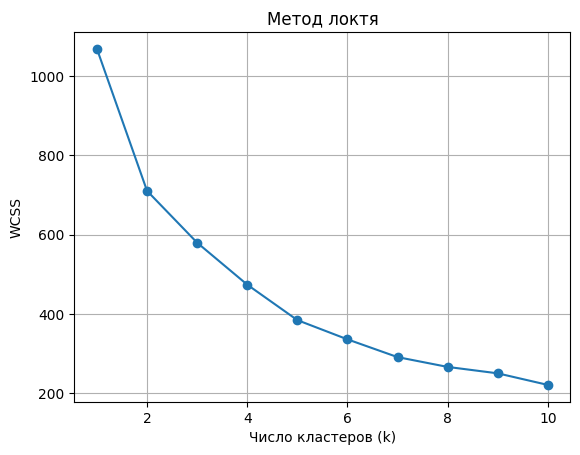

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Метод локтя')
plt.xlabel('Число кластеров (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

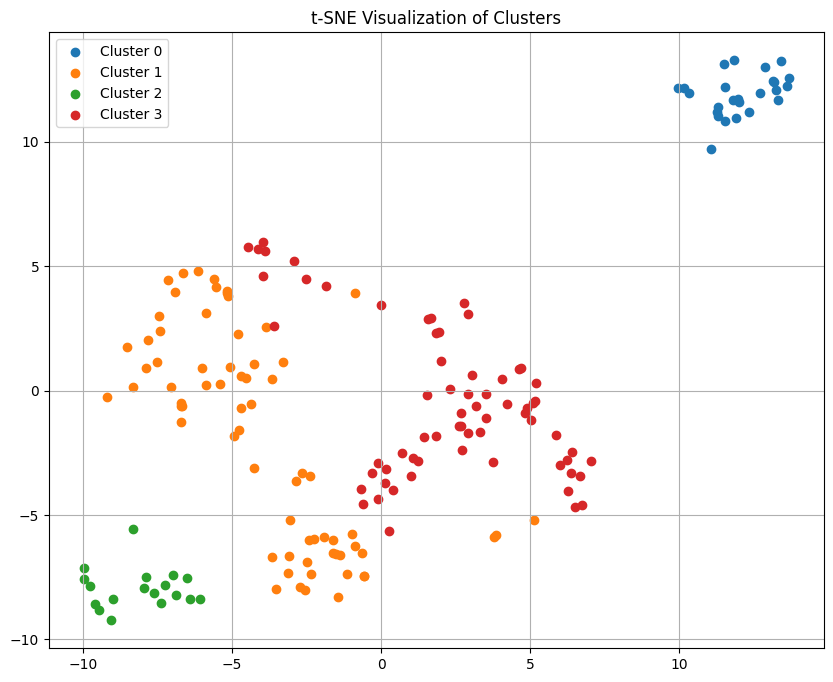

In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(data_scaled)

data['Cluster'] = clusters

from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

data_tsne_df = pd.DataFrame(data_tsne, columns=['TSNE1', 'TSNE2'])
data_tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_data = data_tsne_df[data_tsne_df['Cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'Cluster {cluster}')
plt.title('t-SNE Visualization of Clusters')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for col in categorical_cols:
    le = label_encoders[col]
    data[col] = le.inverse_transform(data[col].astype(int))

for cluster in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster]
    print(f"\nАНАЛИЗ КЛАСТЕРА {cluster}")
    print(f"\nКоличество записей: {len(cluster_data)}")

    print("\nЧисловые характеристики:")
    print(cluster_data['Date of the Crime'].describe())

    for col in categorical_cols:
        print(f"\nРаспределение по '{col}':")
        print(cluster_data[col].value_counts().to_frame())


АНАЛИЗ КЛАСТЕРА 0

Количество записей: 25

Числовые характеристики:
count      25.000000
mean     1979.400000
std        27.654114
min      1855.000000
25%      1977.000000
50%      1983.000000
75%      1989.000000
max      2009.000000
Name: Date of the Crime, dtype: float64

Распределение по 'Type of the Crime':
                          count
Type of the Crime              
murder                       21
rape                          1
rape,  murder                 1
sexual abuse of children      1
satanic ritual sex abuse      1

Распределение по 'Location of the Crime':
                       count
Location of the Crime       
Texas                      4
North Carolina             3
California                 3
Florida                    2
Washington                 1
Pennsylvania               1
New York                   1
Alabama                    1
New Jersey                 1
Rhode Island               1
Massachusetts              1
Oregon                     1
Georgia    

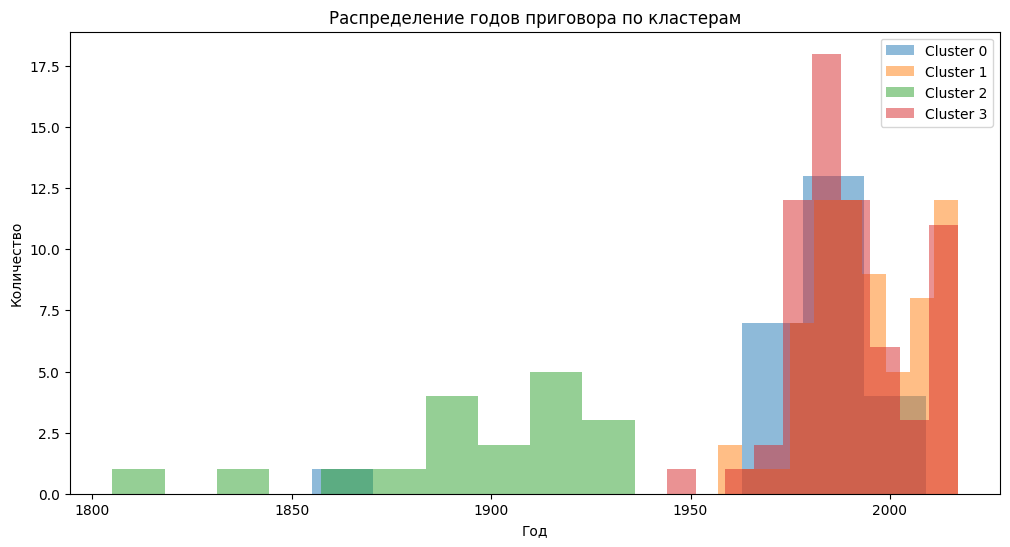

In [ ]:
plt.figure(figsize=(12, 6))
for cluster in range(optimal_k):
    plt.hist(data[data['Cluster'] == cluster]['Date of the Crime'],
             alpha=0.5, label=f'Cluster {cluster}')
plt.title('Распределение годов приговора по кластерам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [ ]:
for cluster in range(optimal_k):
    top_states = data[data['Cluster'] == cluster]['Location of the Crime'].value_counts().head(5)
    print(f"\nТоп-5 штатов в кластере {cluster}:\n{top_states}")


Топ-5 штатов в кластере 0:
Location of the Crime
Texas             4
North Carolina    3
California        3
Florida           2
Washington        1
Name: count, dtype: int64

Топ-5 штатов в кластере 1:
Location of the Crime
Illinois      16
New York       9
Florida        6
California     6
Indiana        5
Name: count, dtype: int64

Топ-5 штатов в кластере 2:
Location of the Crime
Massachusetts    2
Nebraska         2
Illinois         2
Alabama          2
Texas            1
Name: count, dtype: int64

Топ-5 штатов в кластере 3:
Location of the Crime
Texas             11
North Carolina     6
New York           6
Virginia           5
Ohio               5
Name: count, dtype: int64


Кластер 0 — никто не был оправдан , несмотря на жесткие наказания (смерть, пожизненное). Возможно, связь с историческими несправедливыми приговорами, где оправдание не было возможно

Кластер 1 — много данных, объединяет современные оправданные случаи с жесткими наказаниями

Кластер 2 — старые кейсы (XIX век), где оправдание получено намного позже приговора смертной казни. Все индивиды были оправданы, мб связано с пересмотром старых дел

Кластер 3 — современные (после 1944 года) случаи с мягкими наказаниями и высоким уровнем оправданий